In [120]:
import os
import numpy as np
import pandas as pd
from time import time

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
from botorch import acquisition
from botorch import fit_gpytorch_model
from botorch.optim import optimize_acqf
from botorch import fit_fully_bayesian_model_nuts

from gpytorch.constraints import GreaterThan

from botorch.models import SingleTaskGP, ModelListGP, MultiTaskGP
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood

from botorch.acquisition.monte_carlo import qExpectedImprovement
from botorch.models.fully_bayesian import SaasFullyBayesianSingleTaskGP
from botorch.models.transforms import Standardize
from botorch.test_functions import Branin
from torch.quasirandom import SobolEngine
from torch.optim import SGD

from torch import Tensor
from botorch import acquisition
from botorch.models import SingleTaskGP
from gpytorch.constraints import GreaterThan
from botorch import fit_gpytorch_model
from botorch.optim import optimize_acqf
from botorch.sampling import SobolQMCNormalSampler

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
SMOKE_TEST = os.environ.get("SMOKE_TEST")

In [121]:
lower_bound_x = -5
upper_bound_x = 4

lower_bound_y = -3
upper_bound_y = 7

num_of_points = 20
noise = 0

bounds = torch.tensor([[float(lower_bound_x), float(upper_bound_x)], [
                      float(lower_bound_y), float(upper_bound_y)]])
# use a GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float


### Objective Function & Data


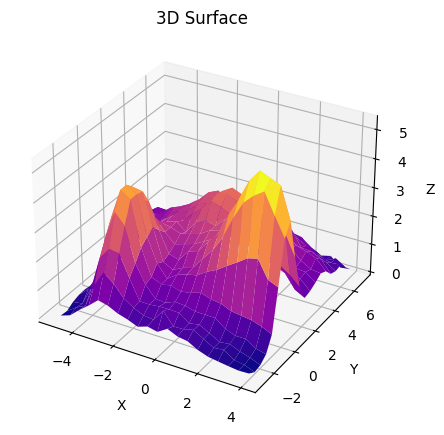

In [122]:
from mpl_toolkits.mplot3d import Axes3D


def generate_3d_data(xmin, xmax, ymin, ymax, line_mesh):

    # The two-dimensional domain of the fit.
    xmin, xmax, nx = xmin, xmax, line_mesh
    ymin, ymax, ny = ymin, ymax, line_mesh
    x, y = np.linspace(xmin, xmax, nx), np.linspace(ymin, ymax, ny)
    X, Y = np.meshgrid(x, y)

    # Our function to fit is going to be a sum of two-dimensional Gaussians
    def gaussian(x, y, x0, y0, xalpha, yalpha, A):
        return A * np.exp( -((x-x0)/xalpha)**2 -((y-y0)/yalpha)**2)

    # A list of the Gaussian parameters: x0, y0, xalpha, yalpha, A
    gprms = [(0, 2, 2.5, 5.4, 1.5),
            (-1, 4, 6, 2.5, 1.8),
            (-3, -0.5, 1, 2, 4),
            (3, 0.5, 2, 1, 5)
            ]

    # Standard deviation of normally-distributed noise to add in generating
    # our test function to fit.
    noise_sigma = 0.1

    # The function to be fit is Z.
    Z = np.zeros(X.shape)
    for p in gprms:
        Z += gaussian(X, Y, *p)
    Z += noise_sigma * np.random.randn(*Z.shape)

    return X, Y, Z


X, Y, Z = generate_3d_data(lower_bound_x, upper_bound_x, lower_bound_y, upper_bound_y, num_of_points)
# Plot the 3D figure of the fitted function and the residuals.
fig = plt.figure(figsize=(5, 5))
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, Z, cmap='plasma')
ax.set_zlim(0,np.max(Z))
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Surface')
plt.show();

In [123]:
df = pd.DataFrame(columns=['X', 'Y', 'Z'], dtype=float)

df['X'] = X.reshape(-1, ).astype(float)
df['Y'] = Y.reshape(-1, ).astype(float)
df['Z'] = Z.reshape(-1, ).astype(float)


train_X , test_X, train_Y, test_Y  = train_test_split(df[['X', "Y"]].values, df[['Z']].values, test_size=0.2)

train_X = torch.tensor(train_X)
test_X = torch.tensor(test_X)
train_Y = torch.tensor(train_Y)
test_Y = torch.tensor(test_Y)

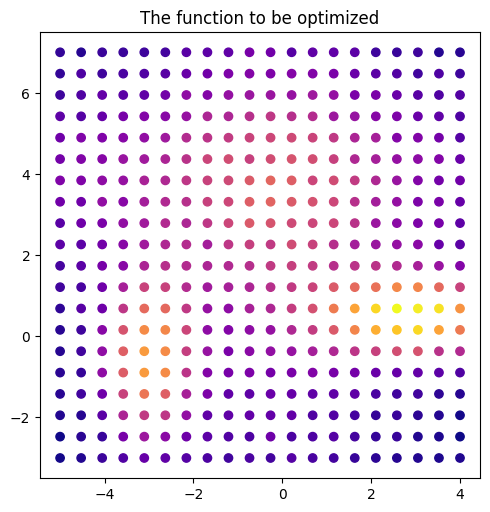

In [134]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.style.context('seaborn-white')
ax.scatter(df['X'], y=df['Y'], c=df['Z'], cmap='plasma')
plt.tight_layout()
plt.title('The function to be optimized')
plt.show()


<Figure size 800x600 with 0 Axes>

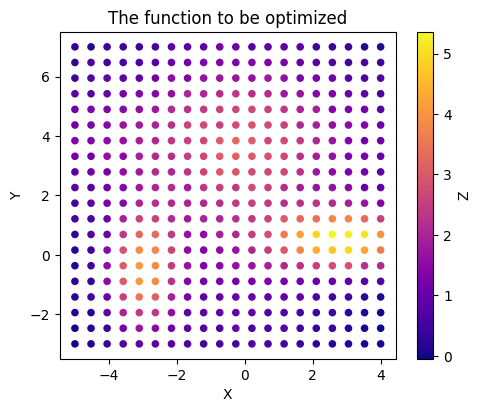

In [124]:
def plotFun(df, next_observed_point, size=(8, 6)):

    fig = plt.figure(figsize=size)
    plt.style.context('seaborn-white')

    ax.scatter(df['X'], y=df['Y'], c=df['Z'], cmap='plasma', figsize=(5, 4))

    if next_observed_point:
            plt.scatter(x=next_observed_point[0],
                        y=next_observed_point[1], c='g', marker="x", linewidth=2)
    plt.tight_layout()

    plt.title('The function to be optimized')
    plt.show()


# plotFun(df, None, size=(8, 6))


### High-Dimensional sample-efficient Bayesian Optimization

In [137]:
def train_model(train_X: Tensor, train_Y: Tensor) -> SingleTaskGP:

    model = SingleTaskGP(train_X, train_Y)
    mll = ExactMarginalLogLikelihood(likelihood=model.likelihood, model=model)
    fit_gpytorch_model(mll)

    return model


model = train_model(train_X, train_Y)


def optimize_acqf_and_get_observation(model, train_X, bounds, n_points=1):
    """ 
    
    A Function to generate the next point to be evaluated.

    Args:
        init_x: The initial point
        init_y: The initial value of the function at the initial point
        best_init_y: The best value of the function seen so far
        bounds: The bounds of the function
        n_points: The number of points to generate

    Returns:
        candidate: Potential next candidate to be evaluated
    """

    acqf = acquisition.qNoisyExpectedImprovement(
        model=model,
        X_baseline=train_X,
        sampler=SobolQMCNormalSampler(1000),
        prune_baseline=True,
    )

    candidate, _ = optimize_acqf(acq_function=acqf,
                                 bounds=bounds,
                                 q=n_points,
                                 num_restarts=100,
                                 raw_samples=512)


    return candidate

Starting iteration 0, total time: 0.001 seconds.
The Best Observed Value: [-4.235255241394043, 4.290637493133545]
Starting iteration 1, total time: 1.414 seconds.
The Best Observed Value: [-3.538661479949951, 5.8223795890808105]
Starting iteration 2, total time: 2.998 seconds.
The Best Observed Value: [-4.982807159423828, 5.297720909118652]
Starting iteration 3, total time: 5.368 seconds.
The Best Observed Value: [-3.9548447132110596, 4.020142555236816]
Starting iteration 4, total time: 6.834 seconds.
The Best Observed Value: [-3.8833155632019043, 6.230096340179443]
Starting iteration 5, total time: 8.413 seconds.
The Best Observed Value: [-4.8238844871521, 6.944421768188477]
Starting iteration 6, total time: 9.977 seconds.
The Best Observed Value: [-3.4114725589752197, 4.695117950439453]
Starting iteration 7, total time: 11.467 seconds.
The Best Observed Value: [-4.786783218383789, 5.853518962860107]
Starting iteration 8, total time: 12.883 seconds.
The Best Observed Value: [-3.299046

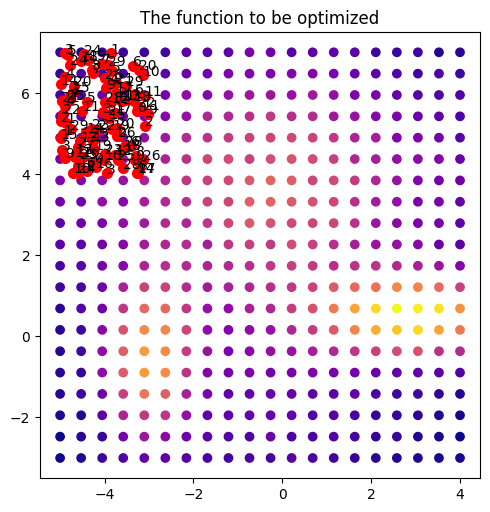

In [139]:
start_time = time()

NUM_ITERATIONS = 30

# Dense grid of points within bounds
for i in range(NUM_ITERATIONS):
    print(
        f"Starting iteration {i}, total time: {time() - start_time:.3f} seconds.")
    candidate = optimize_acqf_and_get_observation(
        model, train_X, bounds, 1)

    observation = model.posterior(candidate).mean.squeeze()
    observation.backward()

    train_X = torch.cat([train_X, candidate])
    train_Y = torch.cat([train_Y, torch.tensor([[observation]])])

    model = train_model(train_X, train_Y)

    next_observed_point = candidate.tolist()[0]

    print(f"The Best Observed Value: {next_observed_point}")

    fig.gca().scatter(
        x=next_observed_point[0], 
        y=next_observed_point[1], color='r', linewidth=2)
    ax.annotate(f'{i}', next_observed_point)
fig